In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tfa-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 9.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Distributed Training
    - TPUs are Application Specific Integrated Circuits(ASIC) designed by Google specifically for tensorflow computations. Hence, the computations on TPUs are extremely efficient.
    - Tensorflow offers a high level API to set our dsitributed training strategy. The strategy integrates with downstream operations.
    - I will use the TPU strategy and setup to take advantage of the 8 cores in a TPU v3-8. Each core has 16 GB of memory so we should easily be able to split 1/8 of a batch and model replica on each core.
    - The TPU strategy runs synchronous distributed training. Each of the model replicas will compute gradients against its split of the batch. Then the strategy will use an all reduce algorithm to compute global gradient and pass the updated weights to each model replica.
    - Tensorflow's docs provides the code to setup the TPU strategy.
    - Tensorflow's distributed training docs https://www.tensorflow.org/guide/distributed_training

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.optimizers import Adam

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Device:', cluster_resolver.master())
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)

print(tf.__version__)

E0000 00:00:1732237449.526632      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1122 01:04:09.534637770      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1122 01:04:09.534654390      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1122 01:04:09.534658258      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1122 01:04:09.534661070      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1122 01:04:09.534663751      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.16.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## TF Records
    - This competition uses TF Records to more easily distribute compute and store the dataset
    - First we'll investifate the example schema then we'll have the proper knowledge to parse the records

In [4]:
# Define a function to print the feature schema of a TFRecord file
def inspect_tfrecord_schema(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        for key in example.features.feature.keys():
            feature = example.features.feature[key]
            kind = feature.WhichOneof('kind')
            print(f'Feature name: {key}, Type: {kind}')

# Inspect your TFRecord file
inspect_tfrecord_schema("/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec")


Feature name: image_name, Type: bytes_list
Feature name: image, Type: bytes_list
Feature name: target, Type: bytes_list


In [5]:
GLOBAL_PATH = "/kaggle/input/gan-getting-started/"

MONET_FILENAMES = tf.io.gfile.glob(str(GLOBAL_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GLOBAL_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


## Image Info
    - The competition page explains that the images are 256 x 256 x 3, meaning the height is 256 pixels, the width is 256 pixels, and there are 3 color channels(RGB).
    - Channel values are [0, 255] and all of these should be normalized to [0, 255]
    - Now that we know the tf example schema, we can parse each tf record to extract images
    - Cycle GANs don't need labels! We used the path to group image types in the previous cell and that is enough separation needed for the images

In [6]:
IMAGE_SZ = [256, 256, 3]

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, IMAGE_SZ)
    return image
    
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

## Input Pipeline Optimizations
    - This environment provides 5 Monet tfRecords and 20 Photo tfRecords. Each record is like a dataset on its own. By first refering to all the records files for a image type, we can setup an interleaving job in the input pipeline. The interleaving job allows multiple I/O calls in parallel. This is a huge time saver as I/O has a high latency
    - We need to read each individual example from the tf records. We can do this work in parallel as well.
    - During training, the CPU is used to run our input pipeline to retrieve the data and transfer to TPUs. 
    Therefore, the CPU is idle while the TPUs train and the TPUs are idle while waiting for a new batch of data. We can prefetch batches, which means the CPU will retrieve batches such that a buffer is ready to distribute amongst TPUs when needed.
    - All these optimizations require a hyperparameter(num_parallel_calls or buffer_size). We could experiment with hardware and see what works best, OR we could use Tensorflow's AUTOTUNE parameter which picks optimal values based on environment settings. I will choose the latter option.

In [25]:
batch_size_per_tpu = 4
num_tpus = tpu_strategy.num_replicas_in_sync 
BATCH_SIZE  = batch_size_per_tpu * num_tpus
print(BATCH_SIZE)

32


In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_dataset(file_ext, batch_size):
    dataset = tf.data.Dataset.list_files(str(GLOBAL_PATH + file_ext))
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [61]:
monet_ds = load_dataset('/monet_tfrec/*.tfrec', BATCH_SIZE)
photo_ds = load_dataset('/photo_tfrec/*.tfrec', BATCH_SIZE)

In [62]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

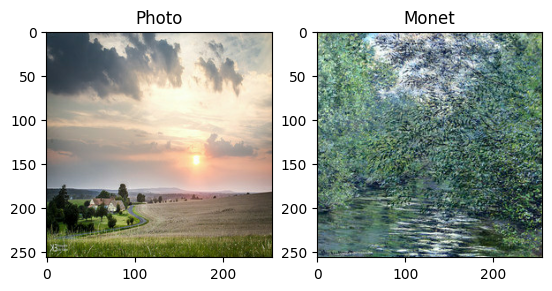

In [63]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [30]:
train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
train_ds = tpu_strategy.experimental_distribute_dataset(train_ds)

## Generator Architecture:
    - The generator follows this pattern: 
        1.) Down-Sampling: Utilize layers of convolutions to learn a latent space representation of images of a particular domain.
        2.) Up-Sampling: Utilize layers of convolution transposes(deconvolution) to expand back to a the higher dimension, but in the new domain, y.

    - This pattern is essentially like an autoencoder! 
    - Remember that the image is 256 x 256 x 3. The goal of down-sampling is to reduce the width & height, but expand the number of channels.
    - Let's explain how to setup a convolution such that each output width & height is halved:
        - Let's set stride to 2 and padding to 'same', so that the output width/height = 
            ceiling(input_dim / stride)
        - By setting padding to 'same', tensorflow will setup padding values on the 2d dimensions(width & 
            height) such that the above output dimension equation holds
        - Stackoverflow detailed explanation: https://stackoverflow.com/questions/68035443/what-does-
            padding-same-exactly-mean-in-tensorflow-conv2d-is-it-minimum-paddin
    - We can then just do the inverse on the upsampling and will get back to the original dimensionality 
        for an input image: (256, 256, 3)!

    - UNet Architecture:
        - It has been proven that deep neural networks, such as this proposed design, have a very slow learning process. This is because the input is essentially reudced to random noise by the end of the network after all these randomly initially assigned weights are applied. The only cause is because gradients don't propagate back to the start weights particularly well in deep neural networks.

        - SOLUTION: Residual Blocks w/ Skip Connections! Models like ResNet revolutionized deep network architecture by resolving the 2 issues explained above. For example, think of any given neural network layer. Conventional architectures ask that layer to learn: h(x) where h(x) is a latent representation of x. This is inefficient in deep networks because we make little use of the information that x the input already provides when passing to the next layer! A skip connection asks a layer to learn the residual r(x), where r(x) = h(x) + x! Hence, the following layers have access to the input x and the additional info extracted from the previous layer. 

        - The next issue: To satisfy the residual equation, we have to be able to add x and h(x). Remember that this generator architecture is essentially symmetric. For each layer in the encode section, there is a matching output size layer in the decode section. The UNet architecture takes advantage of this fact to create skip connections across the encode & decode sections. 

        - Here's the UNET paper for more detailed explanations as I have provided only high level details

In [31]:
def conv_layer(filters, kernel_size, strides=2, padding='same', use_norm=True, activation=True):
    layers_list = [layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)]
    if use_norm:
        layers_list.append(tfa.layers.InstanceNormalization())
    if activation:
        layers_list.append(layers.LeakyReLU(negative_slope=0.2))
    return Sequential(layers_list)

def deconv_layer(filters, kernel_size, strides=2, padding='same', use_norm=True, activation=True):
    layers_list = [layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)]
    if use_norm:
        layers_list.append(tfa.layers.InstanceNormalization())
    if activation:
        layers_list.append(layers.ReLU())
    return Sequential(layers_list)

## Use TensorFlow's Functional API To Create Models
    - By tracing the outputs through all the tensorflow layers with x, a sort of memory is maintained.
    - We can then initialize a Tensorflow.Keras model with a call to Model & passing inputs & x. 

In [32]:
def build_generator():
    inputs = layers.Input(shape=IMAGE_SZ)

    #NOTE: input_width = input_height = 256 = 2^8. So 8 conv_layers to get to 1x1 image w/ many filters
    encode = [
        conv_layer(8, 4),
        conv_layer(16, 4),
        conv_layer(32, 4),
        conv_layer(64, 4),
        conv_layer(128, 4),
        conv_layer(256, 4),
        conv_layer(512, 4),
        conv_layer(512, 4)
    ]

    decode = [
        deconv_layer(512, 4),
        deconv_layer(256, 4),
        deconv_layer(128, 4),
        deconv_layer(64, 4),
        deconv_layer(32, 4),
        deconv_layer(16, 4),
        deconv_layer(8, 4)
    ]

    #One last deconvolution layer to get back to 3 channels for RBG images
    output_layer = layers.Conv2DTranspose(IMAGE_SZ[2], 4, strides=2, padding="same", activation='tanh')

    x = inputs
    skip_connections: list = []
    for conv in encode:
        x = conv(x)
        skip_connections.append(x)

    #remove last skip element since image has 1x1 width x height
    skip_connections.pop()

    for i, deconv in enumerate(decode):
        x = deconv(x)
        x = layers.Concatenate()([x, skip_connections[-1 - i]])

    x = output_layer(x)
    return Model(inputs, x)


## Discriminator Model Architecture:
    - The discriminator is simply a classification neural net that processes images w/ convolutions to learn a latent space representation
    - Again use Tensorflow's Functional API to setup a model by tracing x's path through the layers

In [33]:
def build_discriminator():
    inputs = layers.Input(shape=IMAGE_SZ)
    x = conv_layer(64, 4, strides=2, use_norm=False)(inputs)
    x = conv_layer(128, 4)(x)
    x = conv_layer(256, 4)(x)
    x = conv_layer(512, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return Model(inputs, x)

## Setup CycleGAN & Loss Functions
    - CycleGAN has 2 generators & 2 corresponding discriminators to actually form the cycle
    - There are 4 loss functions:
        - Discriminator Loss: Binary Cross Entropy as an average between 2 loss terms.
            Remember, the discriminator's job is to identify true images as 1 and identify generated images 
            as 0. So, the first BCE expression will compare the real image labels to a matrix of 1's. Then, 
            the other BCE expression will compare the generated image labels to a matrix of 0's. These 
            expressions are averages to give equal weight to both goals.
        - Generator Loss: Binary Cross Entropy. Remember, the generator's goal in a GAN is to get the 
            discriminator to predict all generated images as true images. So, this BCE expression will 
            compare a matrix of 1's to the generated image labels.
        - Cycle Consistency Loss: L1 distance between an original image and the output from a cycle back to 
            that image domain. This term ensures the CycleGAN actually learns an accurate cycle between the 
            image domains! By utilizing the generators to generate images in the source image domain, we 
            can calculate L1 distance between the images to determine cycle accuracy. A lambda 
            hyperparameter term is multiplied by this expression to determine how much weight is actually 
            applied to this loss term.
        - Identity Loss: L1 distance between an image and its generated version. For example, a Monet 
            painting passing through the Monet Generator should output an image that is the same as the 
            input. This function ensures important properties of the input domain are not loss through 
            generation. In this situation, we don't want to lose any styling inherit to Monet paintings. 
            Multiplied by half of LAMBDA mentioned under CC Loss section. This allows us to control weight 
            of expression through same hyperparameter.

    **Loss functions pulled from Tensorflow docs
    https://www.tensorflow.org/tutorials/generative/cyclegan

In [34]:
LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = (real_loss + generated_loss) / 2.0

    return total_disc_loss

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * cycle_loss

def identity_loss(real_image, same_image):
    identity_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * .05 * identity_loss

In [81]:
class CycleGAN(Model):
    def __init__(self):
        super(CycleGAN, self).__init__()

        with tpu_strategy.scope():
            self.monet_generator = build_generator() 
            self.ls_generator = build_generator()  
            self.monet_discriminator = build_discriminator()  
            self.ls_discriminator = build_discriminator()  
        
    def compile(self):
        with tpu_strategy.scope():
            super().compile()
            self.monet_generator_optimizer = Adam(learning_rate=2e-2, beta_1=0.5)
            self.ls_generator_optimizer = Adam(learning_rate=2e-2, beta_1=0.5)
            self.monet_discriminator_optimizer = Adam(learning_rate=2e-2, beta_1=0.5)
            self.ls_discriminator_optimizer = Adam(learning_rate=2e-2, beta_1=0.5)
            
    def get_summaries(self):
        print("Generator Architectures:")
        self.monet_generator.summary()

        print("Discriminator Architectures:")
        self.monet_discriminator.summary()

        print("CycleGAN Architecture:")
        super(CycleGAN, self).summary()

    def call(self, monet_img, ls_img):
        generated_monet = self.monet_generator(ls_img)
        generated_ls = self.monet_generator(monet_img)

        monet_label = self.monet_discriminator(generated_monet)
        ls_label = self.ls_discriminator(generated_ls)
        
    @tf.function
    def train_step(self, batch_input):
        monet_images, landscape_images = batch_input

        with tf.GradientTape(persistent=True) as tape:
            generated_monet = self.monet_generator(landscape_images, training=True)
            ls_to_monet_to_ls = self.ls_generator(generated_monet, training=True)

            generated_ls = self.ls_generator(monet_images, training=True)
            monet_to_ls_to_monet = self.monet_generator(generated_ls, training=True)

            monet_to_monet = self.monet_generator(monet_images, training=True)
            ls_to_ls = self.ls_generator(landscape_images, training=True)

            orig_monet_labels = self.monet_discriminator(monet_images, training=True)
            orig_ls_labels = self.ls_discriminator(landscape_images, training=True)

            gen_monet_labels = self.monet_discriminator(generated_monet, training=True)
            gen_ls_labels = self.ls_discriminator(generated_ls, training=True)

            monet_generator_loss = generator_loss(gen_monet_labels)
            ls_generator_loss = generator_loss(gen_ls_labels)

            complete_cycle_loss = calc_cycle_loss(landscape_images, ls_to_monet_to_ls) + calc_cycle_loss(monet_images, monet_to_ls_to_monet)

            complete_monet_generator_loss = monet_generator_loss + complete_cycle_loss + identity_loss(monet_images, monet_to_monet)
            complete_ls_generator_loss = ls_generator_loss + complete_cycle_loss + identity_loss(landscape_images, ls_to_ls)

            monet_discriminator_loss = discriminator_loss(orig_monet_labels, gen_monet_labels)
            ls_discriminator_loss = discriminator_loss(orig_ls_labels, gen_ls_labels)

        monet_generator_grads = tape.gradient(complete_monet_generator_loss, self.monet_generator.trainable_variables)
        ls_generator_grads = tape.gradient(complete_ls_generator_loss, self.ls_generator.trainable_variables)

        monet_discriminator_grads = tape.gradient(monet_discriminator_loss, self.monet_discriminator.trainable_variables)
        ls_discriminator_grads = tape.gradient(ls_discriminator_loss, self.ls_discriminator.trainable_variables)

        
        #print(monet_generator_grads)
        #print(ls_generator_grads)
        #print(monet_discriminator_grads)
        #print(ls_discriminator_grads)
        self.monet_generator_optimizer.apply_gradients(
            zip(
                monet_generator_grads, 
                self.monet_generator.trainable_variables
            )
        )
        self.ls_generator_optimizer.apply_gradients(
            zip(
                ls_generator_grads, 
                self.ls_generator.trainable_variables
            )
        )
        self.monet_discriminator_optimizer.apply_gradients(
            zip(
                monet_discriminator_grads,
                self.monet_discriminator.trainable_variables
            )
        )
        self.ls_discriminator_optimizer.apply_gradients(
            zip(
                ls_discriminator_grads,
                self.ls_discriminator.trainable_variables
            )
        )

        return {
            "monet_gen_loss": complete_monet_generator_loss,
            "ls_gen_loss": complete_ls_generator_loss,
            "monet_disc_loss": monet_discriminator_loss,
            "ls_disc_loss": ls_discriminator_loss
        }


In [82]:
#tf.config.run_functions_eagerly(True)

In [85]:
with tpu_strategy.scope():
    cyclegan = CycleGAN()
    cyclegan.compile()

print(cyclegan.get_summaries())

Generator Architectures:


Model: "functional_267"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_252     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_228      │ (None, 128, 128,  │        408 │ input_layer_252[… │
│ (Sequential)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_229      │ (None, 64, 64,    │      2,096 │ sequential_228[0… │
│ (Sequential)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_230      │ (None, 32, 32,    │      8,288 │ sequential_229[0… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_231      │ (None, 16, 16,    │     32,960 │ sequential_230[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_232      │ (None, 8, 8, 128) │    131,456 │ sequential_231[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_233      │ (None, 4, 4, 256) │    525,056 │ sequential_232[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_234      │ (None, 2, 2, 512) │  2,098,688 │ sequential_233[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_235      │ (None, 1, 1, 512) │  4,195,840 │ sequential_234[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_236      │ (None, 2, 2, 512) │  4,195,840 │ sequential_235[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_84      │ (None, 2, 2,      │          0 │ sequential_236[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_234[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_237      │ (None, 4, 4, 256) │  4,195,072 │ concatenate_84[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_85      │ (None, 4, 4, 512) │          0 │ sequential_237[0… │
│ (Concatenate)       │                   │            │ sequential_233[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_238      │ (None, 8, 8, 128) │  1,048,960 │ concatenate_85[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_86      │ (None, 8, 8, 256) │          0 │ sequential_238[0… │
│ (Concatenate)       │                   │            │ sequential_232[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_239      │ (None, 16, 16,    │    262,336 │ concatenate_86[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_87      │ (None, 16, 16,    │          0 │ sequential_239[0

 Total params: 16,783,955 (64.03 MB)

 Trainable params: 16,783,955 (64.03 MB)

 Non-trainable params: 0 (0.00 B)

Discriminator Architectures:


Model: "functional_288"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_284 (InputLayer)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_258 (Sequential)     │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_259 (Sequential)     │ (None, 64, 64, 128)    │       131,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_260 (Sequential)     │ (None, 32, 32, 256)    │       525,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_261 (Sequential)     │ (None, 16, 16, 512)    │     2,098,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_12               │ (None, 18, 18, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 18, 18, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

CycleGAN Architecture:


Model: "cycle_gan_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_267 (Functional)     │ (None, 256, 256, 3)    │    16,783,955 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_283 (Functional)     │ (None, 256, 256, 3)    │    16,783,955 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_288 (Functional)     │ (None, 18, 18, 1)      │     2,766,529 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_293 (Functional)     │ (None, 18, 18, 1)      │     2,766,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,100,968 (149.16 MB)

 Trainable params: 39,100,968 (149.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [86]:
cyclegan(example_monet, example_photo)

In [54]:
cyclegan.fit(
        train_ds,
        epochs=75
)

Epoch 1/75


2024-11-22 01:26:09.396419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732238772.186978     751 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e5c32ea4a70c7724:0:0), session_name()
I0000 00:00:1732238800.310581     751 tpu_compile_op_common.cc:245] Compilation of e5c32ea4a70c7724:0:0 with session name  took 28.123555495s and succeeded
I0000 00:00:1732238800.417115     751 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e5c32ea4a70c7724:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15178699780797219669", property.function_library_fingerprint = 3188416048749796917, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z 

9/9 ━━━━━━━━━━━━━━━━━━━━ 108s 121ms/step - ls_disc_loss: 7.1053 - ls_gen_loss: 13.7158 - monet_disc_loss: 5.7314 - monet_gen_loss: 12.6463
Epoch 2/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 3.0374 - ls_gen_loss: 8.5520 - monet_disc_loss: 3.4154 - monet_gen_loss: 9.1174
Epoch 3/75


I0000 00:00:1732238803.053021   75052 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - ls_disc_loss: 1.8372 - ls_gen_loss: 7.5160 - monet_disc_loss: 1.8247 - monet_gen_loss: 7.1082
Epoch 4/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 1.3641 - ls_gen_loss: 6.6780 - monet_disc_loss: 1.3933 - monet_gen_loss: 6.5893
Epoch 5/75


I0000 00:00:1732238806.087005   75887 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 1.3036 - ls_gen_loss: 6.5297 - monet_disc_loss: 1.2055 - monet_gen_loss: 6.3819
Epoch 6/75


I0000 00:00:1732238807.603799   76305 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 1.0247 - ls_gen_loss: 6.5653 - monet_disc_loss: 0.9442 - monet_gen_loss: 6.4103
Epoch 7/75


I0000 00:00:1732238809.115885   76723 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.8797 - ls_gen_loss: 6.2571 - monet_disc_loss: 0.8841 - monet_gen_loss: 6.1816
Epoch 8/75


I0000 00:00:1732238810.654929   77141 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.8591 - ls_gen_loss: 5.7984 - monet_disc_loss: 0.7791 - monet_gen_loss: 5.6631
Epoch 9/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.7513 - ls_gen_loss: 5.8229 - monet_disc_loss: 0.7658 - monet_gen_loss: 5.8050
Epoch 10/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.7741 - ls_gen_loss: 5.8252 - monet_disc_loss: 0.7728 - monet_gen_loss: 5.7342
Epoch 11/75


I0000 00:00:1732238815.246457   78393 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.7173 - ls_gen_loss: 5.5407 - monet_disc_loss: 0.7355 - monet_gen_loss: 5.5720
Epoch 12/75


I0000 00:00:1732238816.785010   78815 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - ls_disc_loss: 0.7615 - ls_gen_loss: 5.8186 - monet_disc_loss: 0.7795 - monet_gen_loss: 5.8109
Epoch 13/75


I0000 00:00:1732238818.341525   79233 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.6873 - ls_gen_loss: 5.8991 - monet_disc_loss: 0.7701 - monet_gen_loss: 5.8888
Epoch 14/75


I0000 00:00:1732238819.857145   79651 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - ls_disc_loss: 0.7106 - ls_gen_loss: 5.3819 - monet_disc_loss: 0.7322 - monet_gen_loss: 5.3723
Epoch 15/75


I0000 00:00:1732238821.375100   80069 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - ls_disc_loss: 0.7183 - ls_gen_loss: 5.0541 - monet_disc_loss: 0.7184 - monet_gen_loss: 5.0499
Epoch 16/75


I0000 00:00:1732238822.932418   80487 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.7436 - ls_gen_loss: 5.3295 - monet_disc_loss: 0.7633 - monet_gen_loss: 5.3737
Epoch 17/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - ls_disc_loss: 0.6983 - ls_gen_loss: 5.3510 - monet_disc_loss: 0.7492 - monet_gen_loss: 5.3836
Epoch 18/75


I0000 00:00:1732238826.079908   81322 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.6677 - ls_gen_loss: 5.0561 - monet_disc_loss: 0.7374 - monet_gen_loss: 5.0897
Epoch 19/75


I0000 00:00:1732238827.638633   81740 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.7056 - ls_gen_loss: 4.9722 - monet_disc_loss: 0.7099 - monet_gen_loss: 4.8987
Epoch 20/75


I0000 00:00:1732238829.152604   82158 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6982 - ls_gen_loss: 5.0566 - monet_disc_loss: 0.7326 - monet_gen_loss: 5.0682
Epoch 21/75


I0000 00:00:1732238830.715201   82576 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.7267 - ls_gen_loss: 4.5793 - monet_disc_loss: 0.7046 - monet_gen_loss: 4.5323
Epoch 22/75


I0000 00:00:1732238832.254826   82994 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.6888 - ls_gen_loss: 4.6210 - monet_disc_loss: 0.7179 - monet_gen_loss: 4.6295
Epoch 23/75


I0000 00:00:1732238833.803786   83412 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.7188 - ls_gen_loss: 4.7952 - monet_disc_loss: 0.6841 - monet_gen_loss: 4.7797
Epoch 24/75


I0000 00:00:1732238835.339402   83830 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6778 - ls_gen_loss: 4.8145 - monet_disc_loss: 0.7425 - monet_gen_loss: 4.8138
Epoch 25/75


I0000 00:00:1732238836.847995   84248 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6981 - ls_gen_loss: 4.8777 - monet_disc_loss: 0.7080 - monet_gen_loss: 4.8309
Epoch 26/75


I0000 00:00:1732238838.403905   84666 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - ls_disc_loss: 0.6902 - ls_gen_loss: 4.9016 - monet_disc_loss: 0.7242 - monet_gen_loss: 4.8261
Epoch 27/75


I0000 00:00:1732238839.912889   85084 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - ls_disc_loss: 0.6913 - ls_gen_loss: 4.6652 - monet_disc_loss: 0.7325 - monet_gen_loss: 4.6092
Epoch 28/75


I0000 00:00:1732238841.400556   85502 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - ls_disc_loss: 0.6573 - ls_gen_loss: 4.8360 - monet_disc_loss: 0.6685 - monet_gen_loss: 4.8488
Epoch 29/75


I0000 00:00:1732238842.962027   85920 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.7178 - ls_gen_loss: 4.2657 - monet_disc_loss: 0.9430 - monet_gen_loss: 4.4721
Epoch 30/75


I0000 00:00:1732238844.506555   86338 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6661 - ls_gen_loss: 4.5088 - monet_disc_loss: 0.7127 - monet_gen_loss: 4.4370
Epoch 31/75


I0000 00:00:1732238846.036901   86756 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6901 - ls_gen_loss: 4.3491 - monet_disc_loss: 0.7026 - monet_gen_loss: 4.2715
Epoch 32/75


I0000 00:00:1732238847.565302   87178 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6760 - ls_gen_loss: 4.6914 - monet_disc_loss: 0.6922 - monet_gen_loss: 4.6536
Epoch 33/75


I0000 00:00:1732238849.089033   87596 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - ls_disc_loss: 0.6890 - ls_gen_loss: 4.9928 - monet_disc_loss: 0.6922 - monet_gen_loss: 4.9315
Epoch 34/75


I0000 00:00:1732238850.667990   88014 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6930 - ls_gen_loss: 4.5365 - monet_disc_loss: 0.6802 - monet_gen_loss: 4.5235
Epoch 35/75


I0000 00:00:1732238852.214369   88432 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6576 - ls_gen_loss: 4.2949 - monet_disc_loss: 0.6915 - monet_gen_loss: 4.2485
Epoch 36/75


I0000 00:00:1732238853.731853   88850 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - ls_disc_loss: 0.6712 - ls_gen_loss: 4.5120 - monet_disc_loss: 0.6949 - monet_gen_loss: 4.4923
Epoch 37/75


I0000 00:00:1732238860.184791   89268 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.7037 - ls_gen_loss: 4.6597 - monet_disc_loss: 0.6965 - monet_gen_loss: 4.6306
Epoch 38/75


I0000 00:00:1732238861.737157   89686 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6721 - ls_gen_loss: 4.1519 - monet_disc_loss: 0.6855 - monet_gen_loss: 4.1247
Epoch 39/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.6593 - ls_gen_loss: 4.4936 - monet_disc_loss: 0.6780 - monet_gen_loss: 4.4184
Epoch 40/75


I0000 00:00:1732238864.909670   90521 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.6722 - ls_gen_loss: 4.3147 - monet_disc_loss: 0.7103 - monet_gen_loss: 4.2863
Epoch 41/75


I0000 00:00:1732238866.437461   90939 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6566 - ls_gen_loss: 4.4939 - monet_disc_loss: 0.6710 - monet_gen_loss: 4.4197
Epoch 42/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6655 - ls_gen_loss: 4.3277 - monet_disc_loss: 0.7118 - monet_gen_loss: 4.3220
Epoch 43/75


I0000 00:00:1732238869.513106   91774 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - ls_disc_loss: 0.6897 - ls_gen_loss: 4.4118 - monet_disc_loss: 0.6831 - monet_gen_loss: 4.3912
Epoch 44/75


I0000 00:00:1732238871.102324   92192 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.6923 - ls_gen_loss: 4.3491 - monet_disc_loss: 0.6808 - monet_gen_loss: 4.3549
Epoch 45/75


I0000 00:00:1732238872.617330   92610 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - ls_disc_loss: 0.6536 - ls_gen_loss: 4.3632 - monet_disc_loss: 0.7174 - monet_gen_loss: 4.3318
Epoch 46/75


I0000 00:00:1732238874.237487   93028 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - ls_disc_loss: 0.6672 - ls_gen_loss: 4.3458 - monet_disc_loss: 0.6626 - monet_gen_loss: 4.2814
Epoch 47/75


I0000 00:00:1732238875.804618   93446 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - ls_disc_loss: 0.6574 - ls_gen_loss: 4.0594 - monet_disc_loss: 0.6714 - monet_gen_loss: 4.1098
Epoch 48/75


I0000 00:00:1732238877.366376   93869 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6662 - ls_gen_loss: 3.9285 - monet_disc_loss: 0.7079 - monet_gen_loss: 3.9231
Epoch 49/75


I0000 00:00:1732238878.882104   94287 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6642 - ls_gen_loss: 4.2670 - monet_disc_loss: 0.6717 - monet_gen_loss: 4.2652
Epoch 50/75


I0000 00:00:1732238880.446344   94705 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - ls_disc_loss: 0.6448 - ls_gen_loss: 4.3149 - monet_disc_loss: 0.6803 - monet_gen_loss: 4.3194
Epoch 51/75


I0000 00:00:1732238881.947818   95123 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - ls_disc_loss: 0.6461 - ls_gen_loss: 4.0244 - monet_disc_loss: 0.6897 - monet_gen_loss: 4.1032
Epoch 52/75


I0000 00:00:1732238883.509352   95541 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - ls_disc_loss: 0.7452 - ls_gen_loss: 4.6707 - monet_disc_loss: 0.6824 - monet_gen_loss: 4.6115
Epoch 53/75


I0000 00:00:1732238885.085542   95959 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - ls_disc_loss: 0.6826 - ls_gen_loss: 3.8588 - monet_disc_loss: 0.6353 - monet_gen_loss: 4.0626
Epoch 54/75


I0000 00:00:1732238886.605283   96377 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - ls_disc_loss: 0.6693 - ls_gen_loss: 4.0288 - monet_disc_loss: 0.7247 - monet_gen_loss: 4.0909
Epoch 55/75


I0000 00:00:1732238888.107404   96795 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6805 - ls_gen_loss: 4.1881 - monet_disc_loss: 0.6846 - monet_gen_loss: 4.2574
Epoch 56/75


I0000 00:00:1732238889.650448   97213 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.6498 - ls_gen_loss: 4.2197 - monet_disc_loss: 0.6401 - monet_gen_loss: 4.2010
Epoch 57/75


I0000 00:00:1732238891.206889   97631 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6882 - ls_gen_loss: 3.8679 - monet_disc_loss: 0.6945 - monet_gen_loss: 3.9275
Epoch 58/75


I0000 00:00:1732238892.738189   98049 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - ls_disc_loss: 0.6457 - ls_gen_loss: 4.1778 - monet_disc_loss: 0.6593 - monet_gen_loss: 4.2631
Epoch 59/75


I0000 00:00:1732238894.282606   98467 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - ls_disc_loss: 0.6511 - ls_gen_loss: 3.9066 - monet_disc_loss: 0.6682 - monet_gen_loss: 3.9316
Epoch 60/75


I0000 00:00:1732238895.858034   98885 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.6338 - ls_gen_loss: 3.7962 - monet_disc_loss: 0.6883 - monet_gen_loss: 3.8283
Epoch 61/75


I0000 00:00:1732238897.401631   99303 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6669 - ls_gen_loss: 3.8613 - monet_disc_loss: 0.6990 - monet_gen_loss: 3.7828
Epoch 62/75


I0000 00:00:1732238898.956797   99721 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - ls_disc_loss: 0.7023 - ls_gen_loss: 3.7644 - monet_disc_loss: 0.6656 - monet_gen_loss: 3.6857
Epoch 63/75


I0000 00:00:1732238900.485143  100139 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6721 - ls_gen_loss: 3.7971 - monet_disc_loss: 0.6643 - monet_gen_loss: 3.8821
Epoch 64/75


I0000 00:00:1732238902.008219  100557 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6630 - ls_gen_loss: 3.7686 - monet_disc_loss: 0.6826 - monet_gen_loss: 3.8984
Epoch 65/75


I0000 00:00:1732238903.535421  100975 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6500 - ls_gen_loss: 4.2465 - monet_disc_loss: 0.6680 - monet_gen_loss: 4.3101
Epoch 66/75


I0000 00:00:1732238905.107079  101393 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - ls_disc_loss: 0.6832 - ls_gen_loss: 3.9560 - monet_disc_loss: 0.6809 - monet_gen_loss: 3.9684
Epoch 67/75


I0000 00:00:1732238906.600373  101816 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6994 - ls_gen_loss: 3.8246 - monet_disc_loss: 0.6461 - monet_gen_loss: 3.9262
Epoch 68/75


I0000 00:00:1732238908.139076  102234 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - ls_disc_loss: 0.6761 - ls_gen_loss: 3.8410 - monet_disc_loss: 0.7173 - monet_gen_loss: 3.8813
Epoch 69/75


I0000 00:00:1732238909.693254  102652 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - ls_disc_loss: 0.6806 - ls_gen_loss: 3.6614 - monet_disc_loss: 0.6218 - monet_gen_loss: 3.7204
Epoch 70/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.6818 - ls_gen_loss: 3.8029 - monet_disc_loss: 0.7231 - monet_gen_loss: 3.8363
Epoch 71/75


I0000 00:00:1732238912.787096  103487 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - ls_disc_loss: 0.6268 - ls_gen_loss: 3.7791 - monet_disc_loss: 0.6504 - monet_gen_loss: 3.9202
Epoch 72/75


I0000 00:00:1732238914.358299  103905 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - ls_disc_loss: 0.6508 - ls_gen_loss: 3.6644 - monet_disc_loss: 0.7021 - monet_gen_loss: 3.7176
Epoch 73/75


I0000 00:00:1732238915.925646  104323 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - ls_disc_loss: 0.7015 - ls_gen_loss: 3.9786 - monet_disc_loss: 0.6885 - monet_gen_loss: 3.8671
Epoch 74/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - ls_disc_loss: 0.6612 - ls_gen_loss: 3.8901 - monet_disc_loss: 0.6760 - monet_gen_loss: 4.0184
Epoch 75/75


I0000 00:00:1732238918.982936  105158 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - ls_disc_loss: 0.6584 - ls_gen_loss: 3.6708 - monet_disc_loss: 0.7128 - monet_gen_loss: 3.6709


I0000 00:00:1732238920.529202  105576 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.


In [55]:
#function from https://www.kaggle.com/code/andreynesterov/monet-cyclegan-with-better-cycles#Plot-predictions-
def plot_predictions(model, ds):
    ds_iter = iter(ds)
    for n_sample in range(8):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample, verbose=0)
        f = plt.figure(figsize=(13, 13))
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

2024-11-22 01:29:17.998514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_183_1/conv2d_transpose_71_1/Reshape/ReadVariableOp.
I0000 00:00:1732238958.134241     776 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7e44ab6c7e9d43fe:0:0), session_name()
I0000 00:00:1732238961.218203     776 tpu_compile_op_common.cc:245] Compilation of 7e44ab6c7e9d43fe:0:0 with session name  took 3.083909011s and succeeded
I0000 00:00:1732238961.224416     776 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7e44ab6c7e9d43fe:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3453599501314940040", property.function_library_fingerprint = 7747966839580338472, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.ch

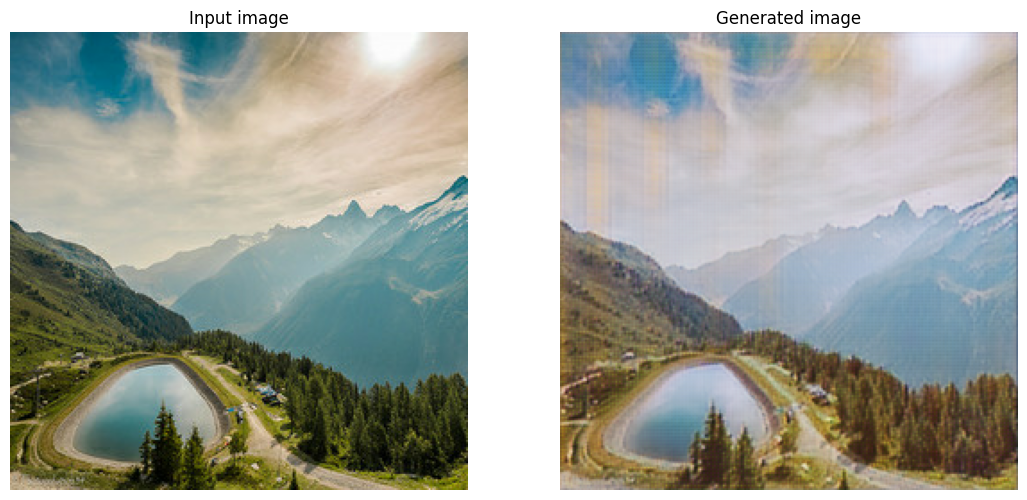

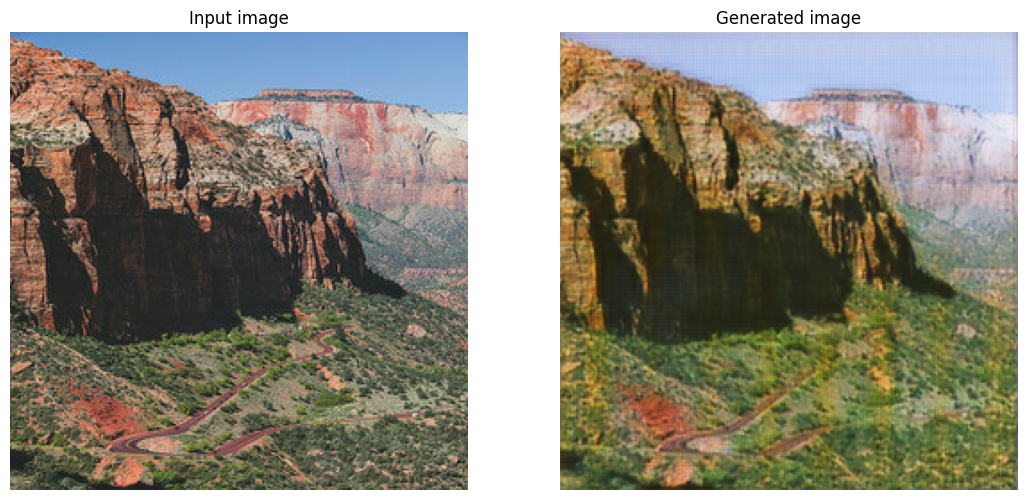

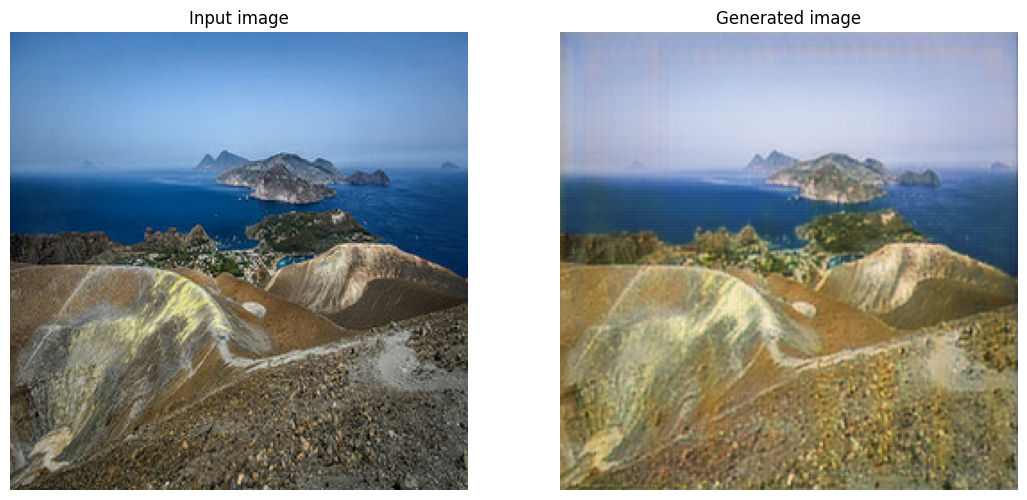

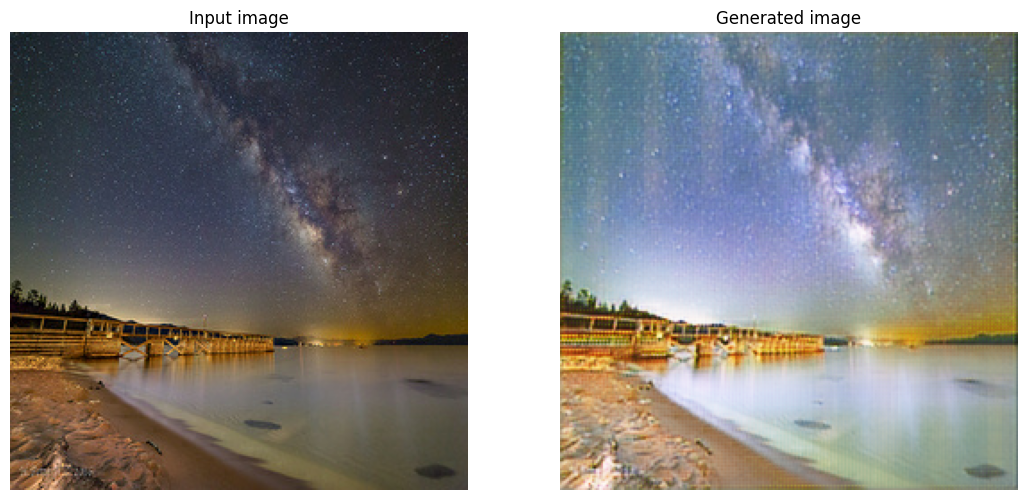

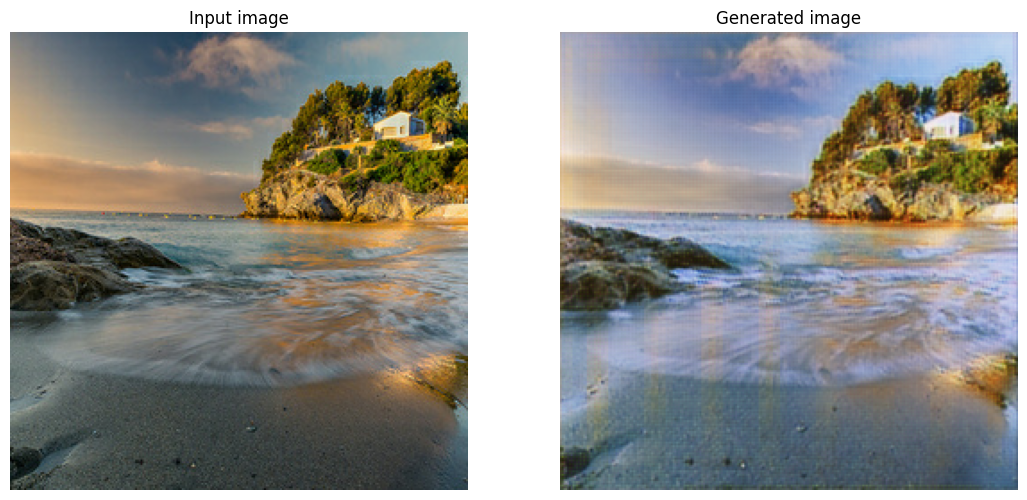

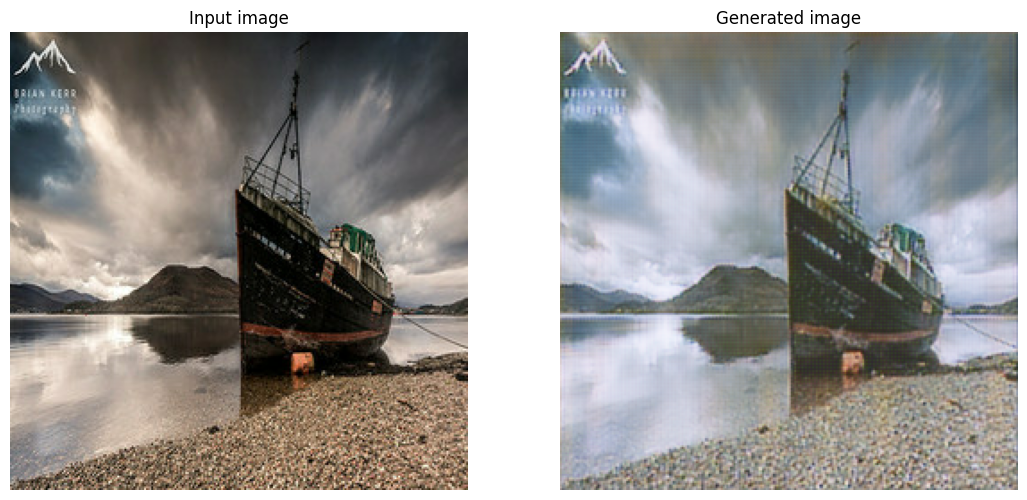

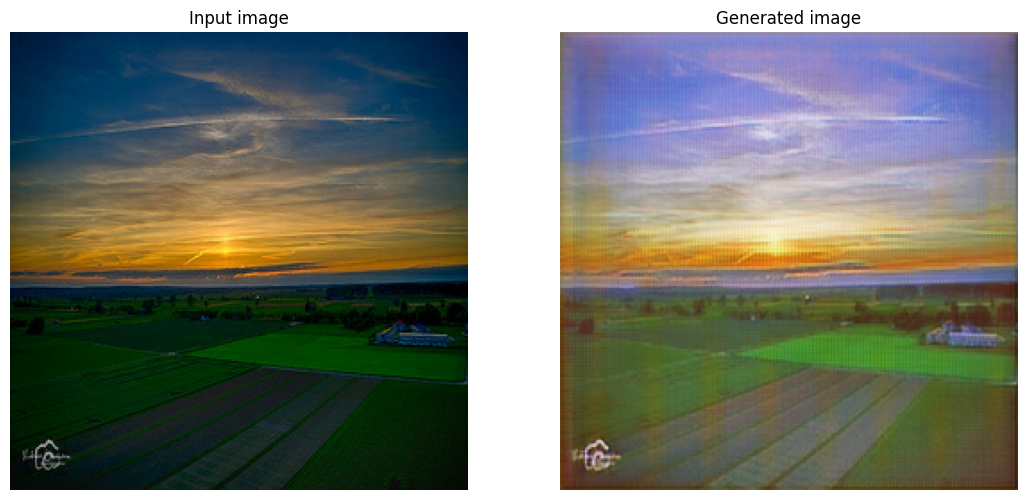

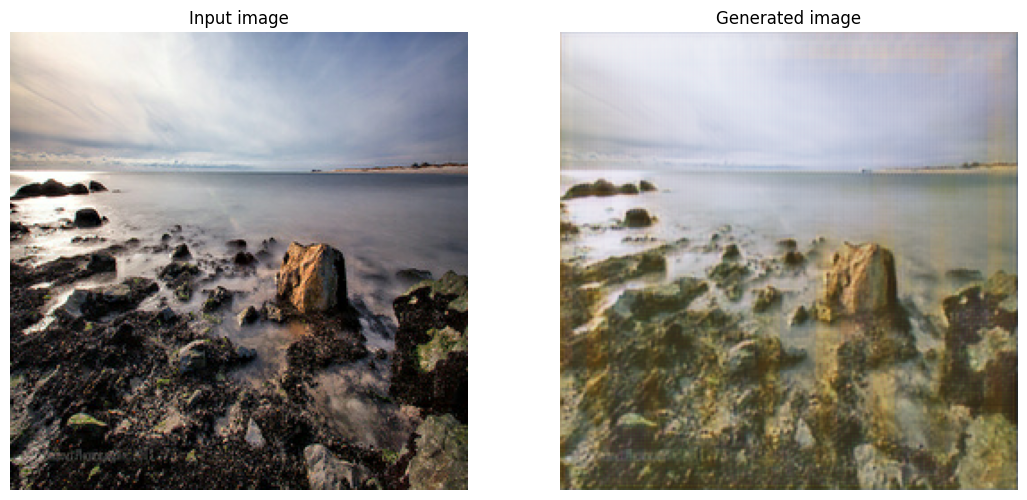

In [56]:
plot_predictions(cyclegan.monet_generator, photo_ds.shuffle(1000))

## Conclusion
    - Clearly the generated images are not quite 'Monet" like. The original photo can be seen, but the quality is poor on the Monet generator output.
    - The training output indicates the generators and discriminators are learning, even when training stops.
    - I think with more compute, I could run an even longer training job and get the more desirable, Monet-like output.
    - Also, I could create larger generator and discriminator models. The models are fairly small and by throwing more parameters on, it has been proven that neural networks can approximate more complex functions. 
    - Further, all optimizers use the same learning rate, I should realistically try hyperparameter tuning if more comppute was given for the task.

## Submission
    - Generate Monet images for all photos and store in an images directory.
    - Zip and store in working directory for submission
    - Code pulled from https://www.kaggle.com/code/andreynesterov/monet-cyclegan-with-better-cycles#Submission-

In [67]:
test_photo_ds = load_dataset('/photo_tfrec/*.tfrec', 32)

In [76]:
import zipfile
from keras.preprocessing.image import array_to_img
from io import BytesIO

In [77]:
def generate_and_save(generator, ds):
    count = 0
    if os.path.exists('images.zip'):
        os.remove('images.zip')
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for images_batch in ds:
            predictions = generator(images_batch, training=False)
            for pred in predictions:
                count += 1
                generated_image = array_to_img(pred)
                generated_image_bytes = BytesIO()
                generated_image.save(generated_image_bytes, format='JPEG')
                generated_image_bytes.seek(0)
                zipf.writestr(f'generated_image_{count}.jpg', generated_image_bytes.getvalue())
                if count % 1024 == 0:
                    print(f'Archived images: {count}')

In [78]:
generate_and_save(cyclegan.monet_generator, test_photo_ds)

Archived images: 1024
Archived images: 2048
Archived images: 3072
Archived images: 4096
Archived images: 5120
Archived images: 6144
